# 基于深度学习的手写数字识别

本教程改编自[colab.research.google](https://colab.research.google.com/github/chokkan/deeplearningclass/blob/master/mnist.ipynb#scrollTo=OaLeoEcDYVO_)。

我们将构建三种`神经网络`模型，包括`具有单个全连接层的网络`、`具有三个全连接层的网络`和`卷积神经网络`，并在MNIST手写数字识别数据集上验证不同模型的性能。



## 环境配置

在第一节课配置环境的基础上，我们还需要`seaborn库`(数据可视化)和`livelossplot库`(损失、准确率等实时可视化)，可在激活conda环境后用如下命令安装：

`conda install seaborn -y`

`pip install livelossplot`

也可以直接运行如下命令：


In [ ]:
!conda install seaborn -y
!pip install livelossplot

## MNIST数据集读取

MNIST数据集是机器学习领域中非常经典的一个数据集，由`60000`个训练样本和`10000`个测试样本组成，每个样本都是一张28 * 28像素的`手写数字灰度图片`。

数据集存放在当前目录的`mnist.npz`中，数据的读取方法如下：

In [2]:
import numpy as np
data = np.load('mnist.npz')

print(data.__dict__)
print(data['train_x'].shape, data['train_x'].dtype)
print(data['train_y'].shape, data['train_y'].dtype)
print(data['test_x'].shape, data['test_x'].dtype)
print(data['test_y'].shape, data['test_y'].dtype)

{'_files': ['train_x.npy', 'train_y.npy', 'test_x.npy', 'test_y.npy'], 'files': ['train_x', 'train_y', 'test_x', 'test_y'], 'allow_pickle': False, 'pickle_kwargs': {'encoding': 'ASCII', 'fix_imports': True}, 'zip': <zipfile.ZipFile file=<_io.BufferedReader name='mnist.npz'> mode='r'>, 'f': <numpy.lib.npyio.BagObj object at 0x00000221EBB2E508>, 'fid': <_io.BufferedReader name='mnist.npz'>}
(60000, 28, 28) float32
(60000,) uint8
(10000, 28, 28) float32
(10000,) uint8


## MNIST数据可视化
将图像以热度图（heatmap）形式显示，并显示每个像素的数值（保留一位小数）：

5


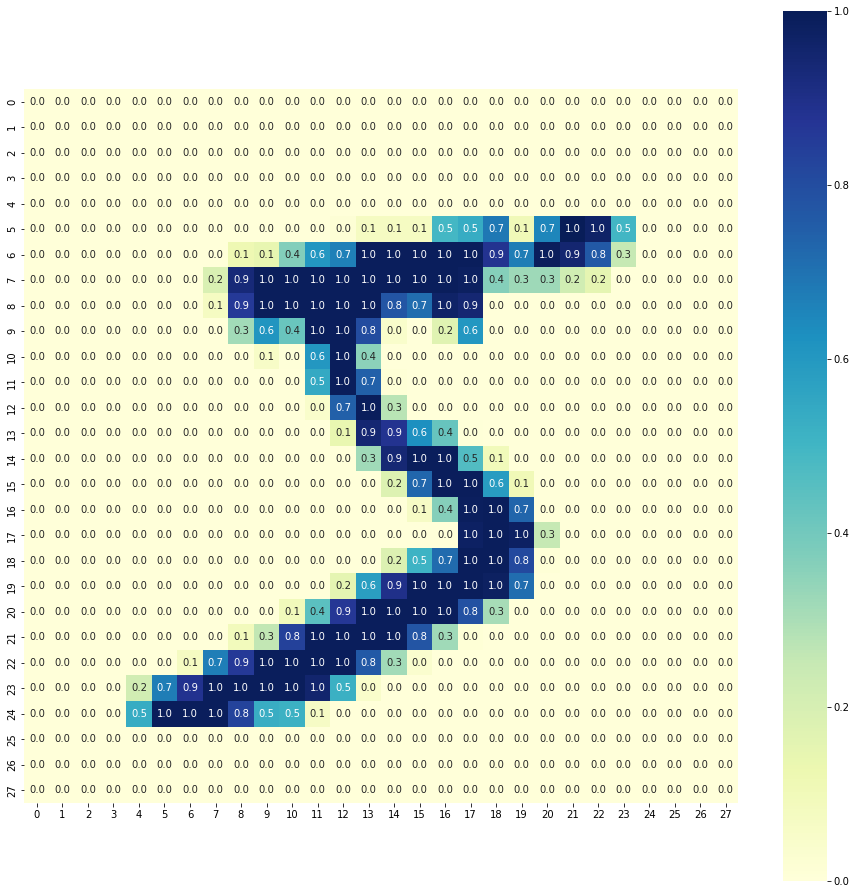

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
data = np.load('mnist.npz')

# 选择可视化的样本
i = 0

image = data['train_x'][i]
label = data['train_y'][i]

print(label)
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(image, annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()

## 数据类型转换

将图像和标签从numpy.ndarray类型转换为torch.Tensor类型：

In [4]:
def create_dataset(x, y, flatten=False):
    if flatten:
        # 转换为2D矩阵 (N [样本数], 28*28),用于单层全连接网络和三层全连接网络
        xt = torch.from_numpy(x).view(len(x), -1)
    else:
        # 转换为4D矩阵 (N [样本数], 1 [通道], 28, 28)，用于卷积神经网络
        xt = torch.from_numpy(x).unsqueeze(1)
    yt = torch.from_numpy(y).long()
    return TensorDataset(xt, yt)

## 模型测试过程的函数定义

In [5]:
def test_model(model, loss_fn, test_loader, device):
    model.eval()

    loss = 0.
    num_correct = 0.
    for batch_idx, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss += loss_fn(y_pred, y).item()
        _, predicted = torch.max(y_pred.data, 1)
        num_correct += (predicted == y).sum().item()

    model.train()
    loss /= len(test_loader.dataset)
    num_correct /= len(test_loader.dataset)
    return loss, num_correct

## 具有单个全连接层的网络

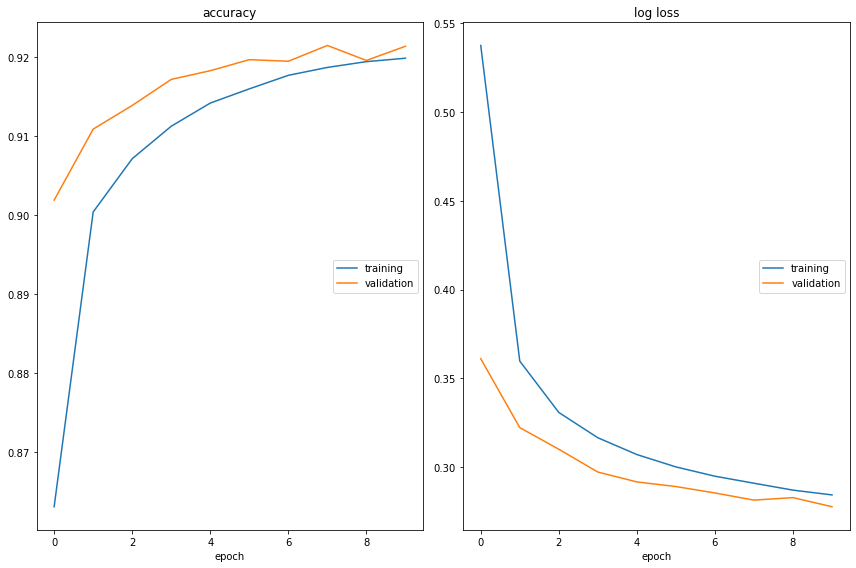

accuracy
	training         	 (min:    0.863, max:    0.920, cur:    0.920)
	validation       	 (min:    0.902, max:    0.921, cur:    0.921)
log loss
	training         	 (min:    0.284, max:    0.537, cur:    0.284)
	validation       	 (min:    0.278, max:    0.361, cur:    0.278)
Accuracy: 0.9214 (test), 0.9199 (train)


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from livelossplot import PlotLosses

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else: 
    device = torch.device("cpu")

model = nn.Sequential()
model.add_module('fc1', nn.Linear(784, 10, bias=True))
print(model)
model.to(device)

data = np.load('mnist.npz')
train_set = create_dataset(data['train_x'], data['train_y'], flatten=True)
test_set = create_dataset(data['test_x'], data['test_y'], flatten=True)
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128)

loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=0.001)

liveloss = PlotLosses()
for t in range(10):
    train_loss = 0.
    train_correct = 0
    
    # 小批量训练循环
    for batch_idx, (x, y) in enumerate(train_loader):

        # 用现在的参数进行预测
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data, 1)
        train_correct += (predicted == y).sum().item()
        
        # 计算损失
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 迭代参数
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # 计算平均损失和准确率
    train_loss /= len(train_loader.dataset)
    train_correct /= float(len(train_loader.dataset))
    
    # 在测试集上测试模型
    test_loss, test_correct = test_model(model, loss_fn, test_loader, device)

    # 可视化损失和准确率的值
    liveloss.update({
        'log loss': train_loss,
        'val_log loss': test_loss,
        'accuracy': train_correct,
        'val_accuracy': test_correct,
    })
    liveloss.draw()

print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(test_correct, train_correct))

## 具有三个全连接层的网络

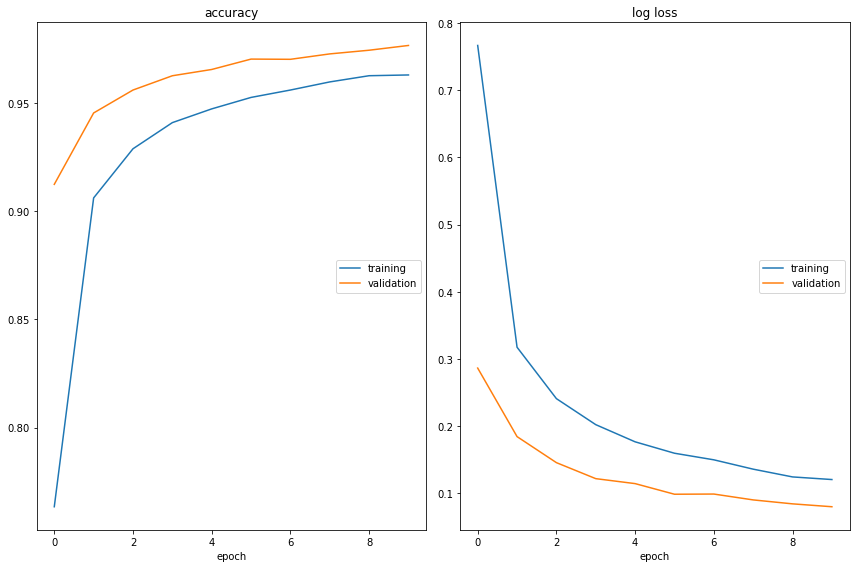

accuracy
	training         	 (min:    0.763, max:    0.963, cur:    0.963)
	validation       	 (min:    0.912, max:    0.977, cur:    0.977)
log loss
	training         	 (min:    0.120, max:    0.767, cur:    0.120)
	validation       	 (min:    0.080, max:    0.286, cur:    0.080)
Accuracy: 0.9766 (test), 0.9630 (train)


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from livelossplot import PlotLosses

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else: 
    device = torch.device("cpu")

model = nn.Sequential()
model.add_module('fc1',      nn.Linear(784, 256))
model.add_module('relu1',    nn.ReLU())
model.add_module('dropout1', nn.Dropout())
model.add_module('fc2',      nn.Linear(256, 256))
model.add_module('relu2',    nn.ReLU())
model.add_module('dropout2', nn.Dropout())
model.add_module('fc3',      nn.Linear(256, 10))
print(model)
model.to(device)

data = np.load('mnist.npz')
train_set = create_dataset(data['train_x'], data['train_y'], flatten=True)
test_set = create_dataset(data['test_x'], data['test_y'], flatten=True)
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128)

loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=0.001)

liveloss = PlotLosses()
for t in range(10):
    train_loss = 0.
    train_correct = 0
    
    # 小批量训练循环
    for batch_idx, (x, y) in enumerate(train_loader):
        
        # 用现在的参数进行预测
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data, 1)
        train_correct += (predicted == y).sum().item()
        
        # 计算损失
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 迭代参数
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # 计算平均损失和准确率
    train_loss /= len(train_loader.dataset)
    train_correct /= float(len(train_loader.dataset))
    
    # 在测试集上测试模型
    test_loss, test_correct = test_model(model, loss_fn, test_loader, device)

    # 可视化损失和准确率的值
    liveloss.update({
        'log loss': train_loss,
        'val_log loss': test_loss,
        'accuracy': train_correct,
        'val_accuracy': test_correct,
    })
    liveloss.draw()

print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(test_correct, train_correct))

## 卷积神经网络

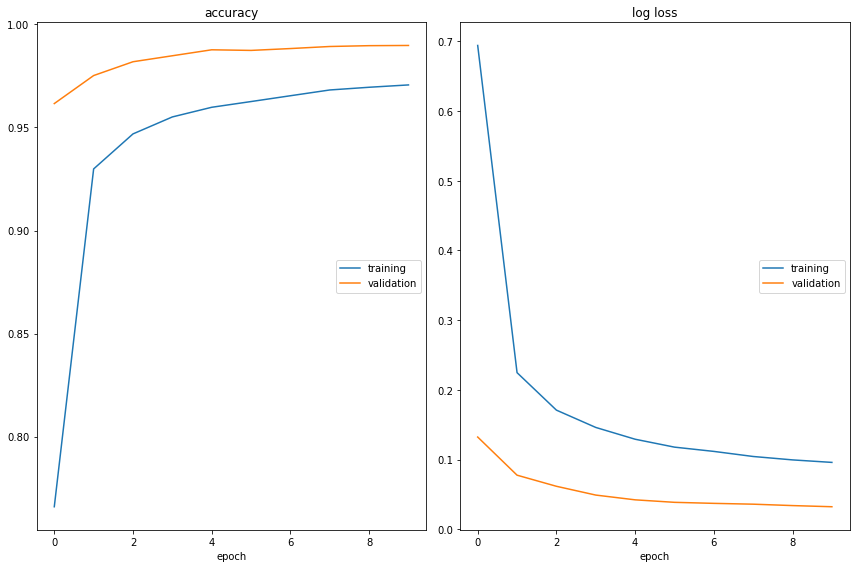

accuracy
	training         	 (min:    0.766, max:    0.971, cur:    0.971)
	validation       	 (min:    0.962, max:    0.990, cur:    0.990)
log loss
	training         	 (min:    0.096, max:    0.694, cur:    0.096)
	validation       	 (min:    0.032, max:    0.132, cur:    0.032)
Accuracy: 0.9898 (test), 0.9707 (train)


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from livelossplot import PlotLosses

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else: 
    device = torch.device("cpu")

class Flatten(torch.nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(-1, 512)

model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 16, (5, 5)),
    torch.nn.MaxPool2d(2),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Conv2d(16, 32, (5, 5)),
    torch.nn.MaxPool2d(2),    
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    Flatten(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(256, 10),
)
print(model)
model.to(device)

data = np.load('mnist.npz')
train_set = create_dataset(data['train_x'], data['train_y'])
test_set = create_dataset(data['test_x'], data['test_y'])
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128)

loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=0.001)

liveloss = PlotLosses()
for t in range(10):
    train_loss = 0.
    train_correct = 0
    
    # 小批量训练循环
    for batch_idx, (x, y) in enumerate(train_loader):
        
        # 用现在的参数进行预测
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data, 1)
        train_correct += (predicted == y).sum().item()
        
        # 计算损失
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 迭代参数
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # 计算平均损失和准确率
    train_loss /= len(train_loader.dataset)
    train_correct /= float(len(train_loader.dataset))
    
    # 在测试集上测试模型
    test_loss, test_correct = test_model(model, loss_fn, test_loader, device)

    # 可视化损失和准确率的值
    liveloss.update({
        'log loss': train_loss,
        'val_log loss': test_loss,
        'accuracy': train_correct,
        'val_accuracy': test_correct,
    })
    liveloss.draw()
    
print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(test_correct, train_correct))